## Problem 2: Calculate and visualise the *dominance areas* of shopping centres (10 points)

In this problem, the aim is to delineate the dominance area of each shopping centre. For this 
exercise, we define the ‘dominance area’ of a shopping centre as the area from which it can 
be reached faster than other shopping centres. We will use public transport travel times.

![](images/dominance_areas_example_1000x500px.png)

*Sample result: a map showing the areas of dominance of each shopping centre, and the travel 
times to the closest shopping centre in the entire metropolitan area*



---

### Data

The **input data** is identical to what you have used for *problem 1*, 
see [there](./Exercise-4-problem-1.ipynb) for detailed data descriptions.

---


### An overview of the tasks

This task comprises of three major subtasks. In contrast to earlier exercises, we 
do not provide a detailed, step-by-step ‘cooking recipe’. Rather, you are free to
implement the necessary steps in any order you see fit, and choose any variable
names of your liking. 

To test intermediate results, implement `assert` statements, output the `head()`
of a data frame, or plot the data. Remember to add comments to all of your code,
so future you (and us) can understand what each section does.

The **only strict requirement** is the **file name** of
the **output** map plot: `DATA_DIRECTORY / "dominance_areas.png"`.

1. Load the YKR grid and the individual travel time data sets, and combine them 
   into one geo data frame. This is essentially the same as *problem 1*, except
   that you must load all eight shopping centre data files. (2 points)
2. Find the closest shopping centre to each grid cell. In the combined data set,
   find the minimum travel time to any of the shopping centres, save the value in
   a new column, and shopping centre name in another new column. (4 points)
   See the [hints](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-4/exercise-4.html#hints)
   to this exercise for a suggestions on how to achieve this 
   ([`pandas.DataFrame.min()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.min.html) and
   [`pandas.DataFrame.idxmin()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html)
   will be helpful)
3. Visualise the dominance areas and travel times. Use 2⨉1 subplots to plot
   the most dominant (closest) shopping centre for each grid cell, and the
   travel time to the closest shopping centre for each grid cell. (4 points)

---


In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import geopandas as gpd

# Load YKR grid gdf
grid = gpd.read_file(DATA_DIRECTORY / "YKR_grid_EPSG3067.gpkg")

grid.head()

,YKR_ID,geometry
0,5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817..."
1,5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820..."
2,5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822..."
3,5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825..."
4,5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810..."


In [3]:
import pandas as pd
import numpy as np

# Create list of travel time/shopping centre data sets
# Use glob() pattern search functionality to find files
# NOTE: glob() returns an iterator
shopping_centres = list(DATA_DIRECTORY.glob("travel_times_to_*"))

# Dictionary to store df
df_dict = {}

# Use for loop to iterate through each travel time/shopping centre data set in the list
for fp in shopping_centres:

    # Convert file name from path object to string using .name attribute
    file_name = fp.name
    
    # Create variable name for each file
    # file_name.split("_") splits the entire file name into a list of parts based on "_" : ["travel", "times", "to", ..., "Jumbo.txt"]
    # [-1] takes the last part of the split list : "Jumbo.txt"
    # split(".")[0] splits the name into parts based on "." and takes the first part of the list : "Jumbo"
    variable_name = file_name.split("_")[-1].split(".")[0]

    # Read the file and assign it to the dictionary
    df_dict[variable_name] = pd.read_csv(fp, sep=";")

df_dict  

{'Jumbo':        from_id    to_id  walk_t  walk_d  car_r_t  car_r_d  car_m_t  car_m_d  \
 0      5785640  5878070     318   22279       39    23233       34    23233   
 1      5785641  5878070     281   19662       39    23444       34    23444   
 2      5785642  5878070     282   19742       45    17666       41    17666   
 3      5785643  5878070     286   20034       46    24695       40    24698   
 4      5787544  5878070     311   21789       38    22807       33    22807   
 ...        ...      ...     ...     ...      ...      ...      ...      ...   
 13226  6016698  5878070     464   32472       58    38658       51    38635   
 13227  6016699  5878070     466   32599       60    38345       53    38323   
 13228  6018252       -1      -1      -1       -1       -1       -1       -1   
 13229  6018253  5878070     469   32829       59    38835       51    38812   
 13230  6018254  5878070     467   32699       61    38933       54    38910   
 
        pt_r_t  pt_r_tt  pt_r

In [4]:
# Loop through each df in dict using .items() function
for key, df in df_dict.items():
    
    # Replace no-data values w/ NaN
    df[df == -1] = np.nan

    # Discard irrelevant columns
    df = df[["from_id", "pt_r_t"]]

    # Rename columns to include reference to shopping centre
    df_dict[key] = df.rename(
        columns={
            "pt_r_t": f"pt_r_t_{key}"
        }
    )

In [5]:
# For two df w/ the same index and length, use join() function
# For two gdf, use spatial join: .sjoin()
# For two df w/ common key attribute, use merge() function

# For two df w/ common key attribute but different column names, set the index of both to refer to the same column and use join() function

# Set indices
grid = grid.set_index("YKR_ID")

for key, df in df_dict.items():
    df_dict[key] = df.set_index("from_id")

# Join df using join() function and specify how parameter
# Left: use calling frame’s index (or column if on is specified)
for key, df in df_dict.items():
    grid = grid.join(df, how="left")

grid.head()

,geometry,pt_r_t_Jumbo,pt_r_t_Dixi,pt_r_t_Myyrmanni,pt_r_t_Itis,pt_r_t_Forum,pt_r_t_Omena,pt_r_t_Ruoholahti
YKR_ID,,,,,,,,
5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817...",101.0,102.0,90.0,132.0,110.0,141.0,118.0
5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820...",108.0,109.0,93.0,135.0,113.0,143.0,121.0
5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822...",109.0,111.0,95.0,137.0,115.0,145.0,123.0
5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825...",114.0,115.0,99.0,141.0,119.0,149.0,127.0
5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810...",98.0,99.0,83.0,125.0,103.0,134.0,111.0


In [13]:
# Select which columns to compare based on integer indexing using .iloc[] function
# Find min travel time using .min() function
# Assign value to new column
grid["min_travel_time"] = grid.iloc[:, 1:8].min(axis=1)

# Find which shopping centre is the closest (has the min travel time) using .idxmin() function
# Assign shopping centre name to new column
grid["closest_shopping_centre"] = grid.iloc[:, 1:8].idxmin(axis=1)

# Split so that output contains only shopping centre name 
grid["closest_shopping_centre"] = grid["closest_shopping_centre"].str.split("_").str[-1]

grid.head()

C:\Users\Steph\AppData\Local\Temp\ipykernel_13884\3635397031.py:8: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  grid["closest_shopping_centre"] = grid.iloc[:, 1:8].idxmin(axis=1)


,geometry,pt_r_t_Jumbo,pt_r_t_Dixi,pt_r_t_Myyrmanni,pt_r_t_Itis,pt_r_t_Forum,pt_r_t_Omena,pt_r_t_Ruoholahti,min_travel_time,closest_shopping_centre
YKR_ID,,,,,,,,,,
5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817...",101.0,102.0,90.0,132.0,110.0,141.0,118.0,90.0,Myyrmanni
5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820...",108.0,109.0,93.0,135.0,113.0,143.0,121.0,93.0,Myyrmanni
5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822...",109.0,111.0,95.0,137.0,115.0,145.0,123.0,95.0,Myyrmanni
5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825...",114.0,115.0,99.0,141.0,119.0,149.0,127.0,99.0,Myyrmanni
5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810...",98.0,99.0,83.0,125.0,103.0,134.0,111.0,83.0,Myyrmanni


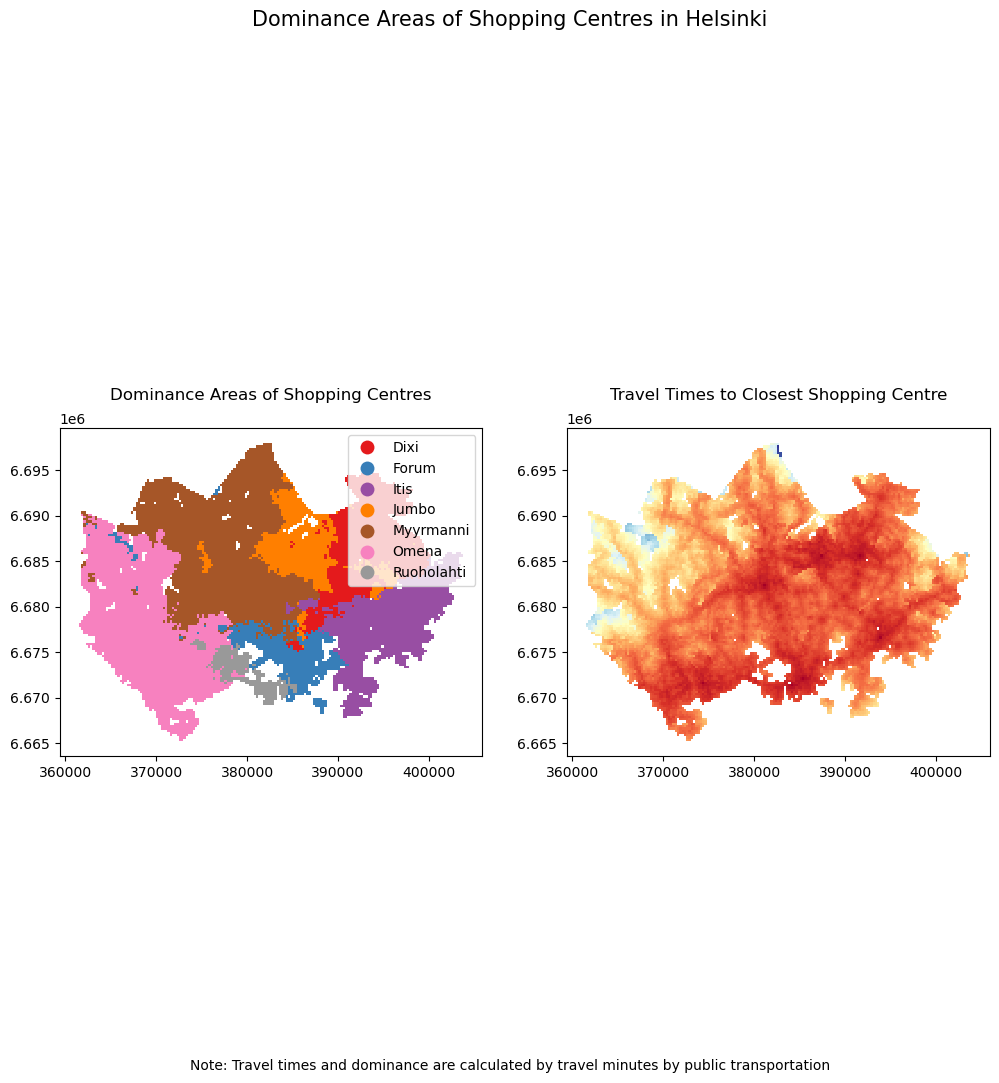

In [15]:
import matplotlib.pyplot as plt

# Create a figure containing two subplots in a 2x1 panel using the .subplots() function from matplotlib
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
axs

# To make it easier to keep track of things, parse these axes into their own variables
ax11 = axs[0]
ax12 = axs[1]

# Set figure title
fig.suptitle("Dominance Areas of Shopping Centres in Helsinki", fontsize=15)

# Set subtitles, font size, padding (vdistance b/w plot and title)
ax11.set_title("Dominance Areas of Shopping Centres", pad=20)
ax12.set_title("Travel Times to Closest Shopping Centre", pad=20)

# Add caption at the bottom of the figure
fig.text(
    0.5,     # Horizontal positioning (x), center of fig
    0.1,    # Vertical positioning (y), bottom of fig
    "Note: Travel times and dominance are calculated by travel minutes by public transportation", 
    ha='center',    # Horizontal alignment (text is centered)
    va='center',    # Vertical alignment
    fontsize=10
)

# Plot most dominant (closest) shopping centre for each grid cell
grid.plot(
    column="closest_shopping_centre",
    ax=ax11,
    linewidth=0,
    legend=True,
    cmap="Set1"
)

# Plot travel time to closest shopping centre for each grid cell
grid.plot(
    column="min_travel_time",
    ax=ax12,
    linewidth=0,
    cmap="RdYlBu"
)

# Write figure to PNG file
plt.savefig(DATA_DIRECTORY / "dominance_areas.png")

In [16]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
assert (DATA_DIRECTORY / "dominance_areas.png").exists()


--- 

**Do not forget to plot the result map, and save it to `DATA_DIRECTORY / "dominance_areas.png"`!**

---

## Reflections

This was a significantly more complex exercise that previous ones, and it included finding
a solution yourself. 

- What was most difficult part? 
- Where did you get stuck? 
- What was the easiest, and
- what was the most fun part of this exercise?

Add your answer below


---

## Well done!

Congratulations, you completed exercise 4. Good Job!